In [ ]:
import pandas as pd
import os
import numpy as np
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/60+0_7_games_share.csv")

In [ ]:
df.loc[df.player_color == "White", 'player_color'] = 1
df.loc[df.player_color == "Black", 'player_color'] = -1
df.drop(columns = ['GameIndex'], inplace = True)

In [ ]:
df_org = df

In [ ]:
df_org

,player,player_color,player_elo,opponent_elo,player_result,0,1,2,3,4,...,51,52,53,54,55,56,57,58,59,60
0,GadeLiO,1,1589,1659,-1,-201.00,-201.00,-201.00,-201.00,-201.00,...,2.84,4.29,3.80,3.80,0.34,-0.63,-0.26,-0.26,-0.26,-0.26
1,sunnyvegas,1,1493,1502,1,-40.80,-12.85,-12.85,-12.14,-201.00,...,-0.74,-0.54,-0.65,-0.63,-1.19,-1.19,-0.73,-1.14,-1.56,-0.15
2,utkuksd2,1,1550,1551,1,201.00,13.26,6.23,4.39,0.03,...,0.22,0.22,0.30,1.10,1.10,0.61,0.61,1.18,1.06,0.71
3,IdeaPolice,1,2313,2307,1,201.00,201.00,201.00,201.00,201.00,...,-0.18,0.16,0.45,-0.27,-0.05,0.44,0.49,0.46,0.50,0.00
4,Raff4ello,1,1114,1227,-1,-0.16,-0.16,-0.16,-0.16,-0.16,...,0.34,0.44,-0.07,0.28,0.00,0.00,0.00,0.00,0.11,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106656,SlappyTaffy1,1,2210,2363,1,-1.95,-1.95,-1.95,-1.95,-1.95,...,201.00,201.00,-0.18,0.77,201.00,201.00,201.00,201.00,0.36,0.36
106657,Willyum_md,1,1316,1220,1,6.06,6.06,4.04,201.00,201.00,...,-0.60,-0.90,-1.13,-5.17,-1.14,-1.14,-0.94,-0.94,0.00,0.23
106658,amorfatti,1,1638,1659,1,11.18,11.18,11.18,11.18,11.18,...,-0.34,-0.08,-0.08,-0.08,-0.08,-0.45,0.42,0.39,0.73,0.82
106659,Macydnah,1,1166,1220,-1,-201.00,-201.00,-201.00,-201.00,-201.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.13,0.03,0.29,0.32


In [ ]:
df_player = df['player'].value_counts().reset_index(name = 'count')
df_player = df_player.sort_values(by = 'count', ascending = False)

In [ ]:
sum(df_player['count'])

949222

# Guessing player ELO?

In [ ]:
!pip install tslearn
from tslearn.neural_network import TimeSeriesMLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.5/368.5 kB 4.4 MB/s eta 0:00:00


## Milestones and Testing

In [ ]:
milestones = [300, 200, 100]
data_size = []
train_val = []
test_val = []
params = []
df_list = []

In [ ]:
for ml in milestones:
  p_list = list(df_player[df_player['count'] >= ml]['index'])
  df = df_org[df_org.player.isin(p_list)]
  data_size.append(len(df))

  mms = MinMaxScaler()
  df_X = mms.fit_transform(df.drop(columns = ['player', 'player_elo']))
  df_y = df['player_elo']
  X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)
  param_grid = [
        {
            'activation' : ['identity', 'logistic', 'tanh', 'relu'],
            'solver' : ['lbfgs', 'sgd', 'adam'],
            'hidden_layer_sizes' : [(16, ), (64, ), (64, 16, ), (64, 64, 16)],
            'max_iter' : [500, 1000, 1500, 2000]
        }
       ]
  clf = GridSearchCV(MLPRegressor(), param_grid, cv=3, scoring='r2')
  clf.fit(X_train,y_train)
  print("Best parameters set found on development set:")
  print(clf.best_params_)
  params.append(clf.best_params_)

  mlp = TimeSeriesMLPRegressor(hidden_layer_sizes=(64, ), random_state=42)
  mlp.fit(X_train, y_train)
  train_score = mlp.score(X_train, y_train)
  test_score = mlp.score(X_test, y_test)
  train_val.append(train_score)
  test_val.append(test_score)
  print(train_score, test_score)

  df_res = pd.DataFrame(y_test)
  df_res.columns = ['y_test']
  df_res['predict'] = mlp.predict(X_test)
  df_list.append(df_res)

In [ ]:
print(params)

[{'activation': 'relu', 'hidden_layer_sizes': (64, 16), 'max_iter': 500, 'solver': 'lbfgs'}, {'activation': 'relu', 'hidden_layer_sizes': (64, 64, 16), 'max_iter': 1000, 'solver': 'adam'}, {'activation': 'relu', 'hidden_layer_sizes': (64, 64, 16), 'max_iter': 500, 'solver': 'lbfgs'}]


In [ ]:
import pickle
with open('/content/drive/MyDrive/60+0_7_full/model.pkl','wb') as f:
    pickle.dump(mlp,f)

In [ ]:
print(data_size)
print(train_val)
print(test_val)
print(params)

[4676, 9405, 30721]
[-0.062297803452557865, 0.39702599414548423, 0.9008579910295222]
[-0.09584600416869171, 0.41017187221739326, 0.8999298246169404]
[{'activation': 'relu', 'hidden_layer_sizes': (64, 16), 'max_iter': 500, 'solver': 'lbfgs'}, {'activation': 'relu', 'hidden_layer_sizes': (64, 64, 16), 'max_iter': 1000, 'solver': 'adam'}, {'activation': 'relu', 'hidden_layer_sizes': (64, 64, 16), 'max_iter': 500, 'solver': 'lbfgs'}]


In [ ]:
with open('/content/drive/MyDrive/60+0_7_full/results.txt', 'w') as writefile:
    writefile.write(str(data_size) + "\n")
    writefile.write(str(train_val) + "\n")
    writefile.write(str(test_val) + "\n")
    writefile.write(str(params) + "\n")

In [ ]:
for i in range(0, len(df_list)):
  dir = "/content/drive/MyDrive/60+0_7_full/data_res_" + str(i) + ".csv"
  df_list[i].to_csv(dir, index = False)

## Just import the results of 2.1

In [ ]:
with open('/content/drive/MyDrive/60+0_7_full/results.txt') as f:
    lines = f.readlines()
res = []
for sub in lines:
    res.append(sub.replace("\n", ""))

In [ ]:
data_size = res[0].strip('][').split(', ')
train_val = res[1].strip('][').split(', ')
test_val = res[2].strip('][').split(', ')

In [ ]:
params_val = res[3][3:-3].split("}, {")

In [ ]:
params_val = res[3][3:-3].split("}, {")
for i in range(0, len(params_val)):
  if(i == 0):
    params_val[i] = params_val[i][:-1]
  elif(i == len(params_val) - 1):
    params_val[i] = params_val[i][1:]
  else:
    params_val[i] = params_val[i][1:-1]
  params_val[i] = "{'" + params_val[i] + "'}"

In [ ]:
import ast
for i in params_val:
  i = ast.literal_eval(i)

In [ ]:
params_val[2]

"{'activation': 'relu', 'hidden_layer_sizes': (64, 64, 16), 'max_iter': 500, 'solver': 'lbfgs'}"

## Result on a larger group of people

In [ ]:
p_list = list(df_player[df_player['count'] >= 50]['index'])
df = df_org[df_org.player.isin(p_list)]

mms = MinMaxScaler()
df_X = mms.fit_transform(df.drop(columns = ['player', 'player_elo']))
df_y = df['player_elo']
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

mlp = TimeSeriesMLPRegressor(activation ='relu',
                             hidden_layer_sizes = (64, 64, 16,),
                             max_iter = 500, solver = 'lbfgs',
                             random_state=42)
mlp.fit(X_train, y_train)
train_score = mlp.score(X_train, y_train)
test_score = mlp.score(X_test, y_test)
print(train_score, test_score)

df_res = pd.DataFrame(y_test)
df_res.columns = ['y_test']
df_res['predict'] = mlp.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.8879654452323451 0.8862782308144108


<Axes: xlabel='y_test', ylabel='predict'>

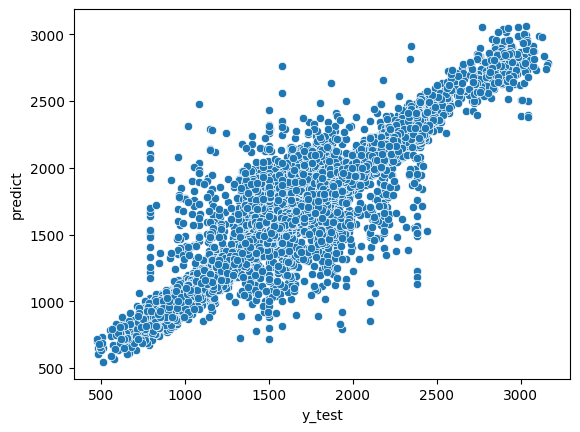

In [ ]:
import seaborn as sns

sns.scatterplot(x="y_test", y="predict", data=df_res)

In [ ]:
X_train_real, X_test_real, not_needed_y, not_needed_y2 = train_test_split(df['opponent_elo'], df_y, test_size=0.2, random_state=42)

In [ ]:
df_res['opponent_elo'] = X_test_real

<Axes: xlabel='y_test', ylabel='opponent_elo'>

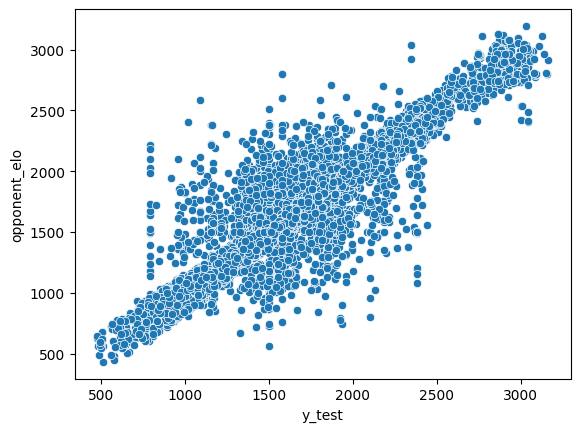

In [ ]:
sns.scatterplot(x="y_test", y="opponent_elo", data=df_res)

<Axes: xlabel='opponent_elo', ylabel='predict'>

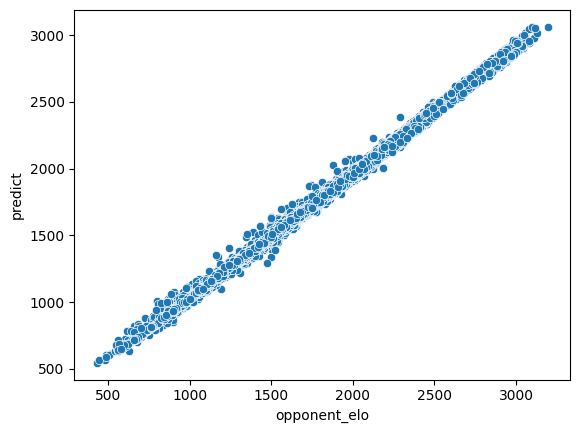

In [ ]:
sns.scatterplot(x="opponent_elo", y="predict", data=df_res)

## Train on the difference

In [ ]:
df_org['elo_difference'] = df_org['player_elo'] - df_org['opponent_elo']

In [ ]:
df_org.columns

Index(['player', 'player_color', 'player_elo', 'opponent_elo', 'player_result',
       '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       'elo_difference'],
      dtype='object')

In [ ]:
import seaborn as sns

<Axes: xlabel='y_test', ylabel='predict'>

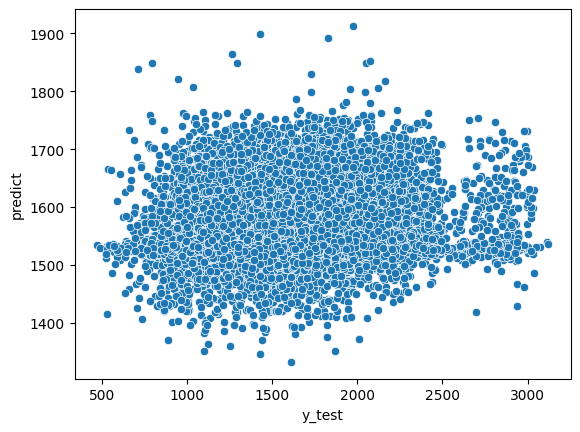

In [ ]:
p_list = list(df_player[df_player['count'] >= 50]['index'])
df = df_org[df_org.player.isin(p_list)]

mms = MinMaxScaler()
df_X = mms.fit_transform(df.drop(columns = ['player', 'player_elo', 'opponent_elo', 'elo_difference', 'player_color', 'player_result']))
df_y = (df['player_elo'] + df['opponent_elo']) / 2
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)
mlp = TimeSeriesMLPRegressor(hidden_layer_sizes = (64, 16,),
                             max_iter = 2000)
mlp.fit(X_train,y_train)
df_res = pd.DataFrame(y_test)
df_res.columns = ['y_test']
df_res['predict'] = mlp.predict(X_test)
sns.scatterplot(x="y_test", y="predict", data=df_res)

<Axes: xlabel='y_test', ylabel='predict'>

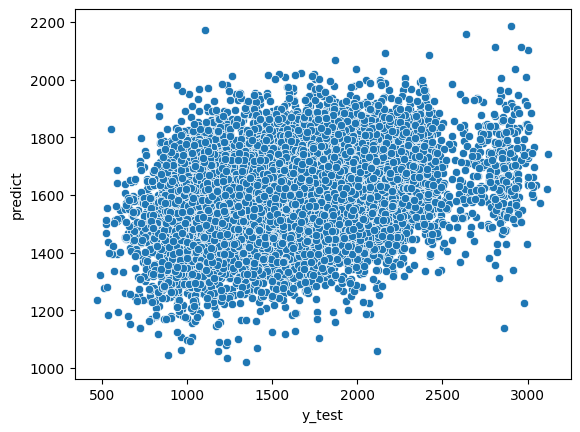

In [ ]:
p_list = list(df_player[df_player['count'] >= 50]['index'])
df = df_org[df_org.player.isin(p_list)]

mms = MinMaxScaler()
df_X = mms.fit_transform(df.drop(columns = ['player', 'player_elo', 'opponent_elo', 'elo_difference', 'player_color', 'player_result']))
df_y = (df['player_elo'] + df['opponent_elo']) / 2
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)
mlp = RandomForestRegressor()
mlp.fit(X_train,y_train)
df_res = pd.DataFrame(y_test)
df_res.columns = ['y_test']
df_res['predict'] = mlp.predict(X_test)
sns.scatterplot(x="y_test", y="predict", data=df_res)

In [ ]:
p_list = list(df_player[df_player['count'] >= 50]['index'])
df = df_org[df_org.player.isin(p_list)]

mms = MinMaxScaler()
df_X = mms.fit_transform(df.drop(columns = ['player', 'player_elo', 'opponent_elo', 'elo_difference', 'player_color', 'player_result']))
df_y = df['elo_difference']
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)
mlp = TimeSeriesMLPRegressor(hidden_layer_sizes = (64, 16,),
                             max_iter = 2000)
mlp.fit(X_train,y_train)

TimeSeriesMLPRegressor(hidden_layer_sizes=(64, 16), max_iter=2000)

<Axes: xlabel='y_test', ylabel='predict'>

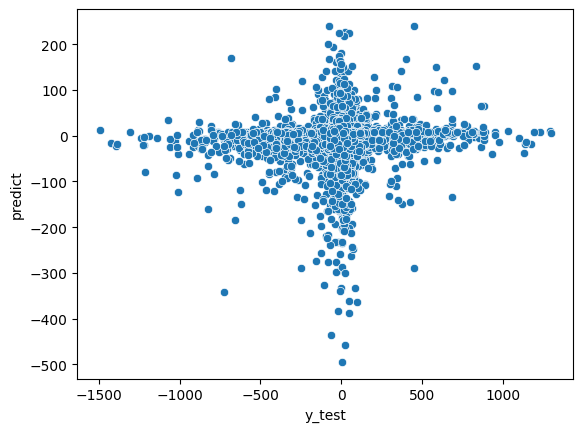

In [ ]:
df_res = pd.DataFrame(y_test)
df_res.columns = ['y_test']
df_res['predict'] = mlp.predict(X_test)

import seaborn as sns

sns.scatterplot(x="y_test", y="predict", data=df_res)

<Axes: xlabel='y_test', ylabel='predict'>

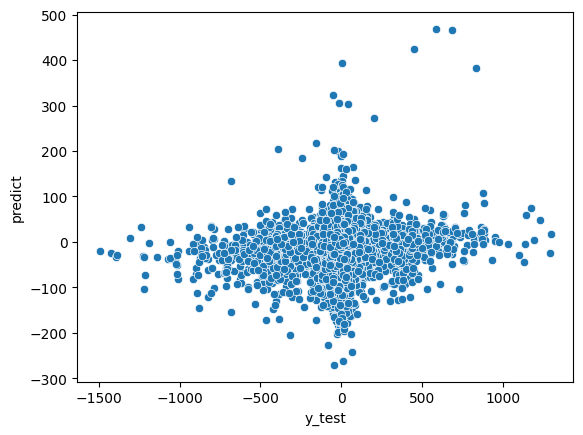

In [ ]:
p_list = list(df_player[df_player['count'] >= 50]['index'])
df = df_org[df_org.player.isin(p_list)]

mms = MinMaxScaler()
df_X = mms.fit_transform(df.drop(columns = ['player', 'player_elo', 'opponent_elo', 'elo_difference', 'player_color', 'player_result']))
df_y = df['elo_difference']
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)
mlp = RandomForestRegressor()
mlp.fit(X_train,y_train)
df_res = pd.DataFrame(y_test)
df_res.columns = ['y_test']
df_res['predict'] = mlp.predict(X_test)
sns.scatterplot(x="y_test", y="predict", data=df_res)

<Axes: xlabel='y_test', ylabel='predict'>

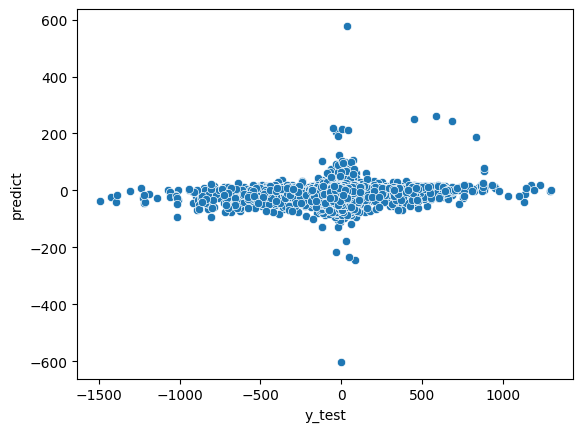

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
p_list = list(df_player[df_player['count'] >= 50]['index'])
df = df_org[df_org.player.isin(p_list)]

mms = MinMaxScaler()
df_X = mms.fit_transform(df.drop(columns = ['player', 'player_elo', 'opponent_elo', 'elo_difference', 'player_color', 'player_result']))
df_y = df['elo_difference']
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)
mlp = GradientBoostingRegressor()
mlp.fit(X_train,y_train)
df_res = pd.DataFrame(y_test)
df_res.columns = ['y_test']
df_res['predict'] = mlp.predict(X_test)
sns.scatterplot(x="y_test", y="predict", data=df_res)

<Axes: xlabel='y_test', ylabel='predict'>

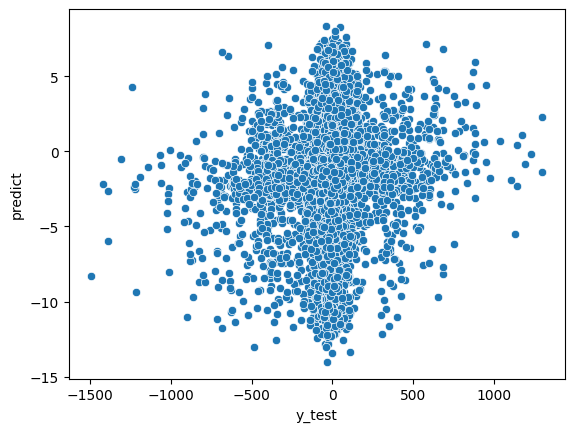

In [ ]:
from sklearn.svm import SVR
p_list = list(df_player[df_player['count'] >= 50]['index'])
df = df_org[df_org.player.isin(p_list)]

mms = MinMaxScaler()
df_X = mms.fit_transform(df.drop(columns = ['player', 'player_elo', 'opponent_elo', 'elo_difference', 'player_color', 'player_result']))
df_y = df['elo_difference']
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)
mlp = SVR()
mlp.fit(X_train,y_train)
df_res = pd.DataFrame(y_test)
df_res.columns = ['y_test']
df_res['predict'] = mlp.predict(X_test)
sns.scatterplot(x="y_test", y="predict", data=df_res)

In [ ]:
import tensorflow as tf
import keras
from keras import layers

In [ ]:
X_train.shape

(65305, 61)

In [ ]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=63, output_dim=64))
model.add(layers.GRU(256, return_sequences=True))
model.add(layers.SimpleRNN(128))
model.add(layers.Dense(10))
model.add(layers.Dense(1))

In [ ]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer="adam",
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

In [ ]:
model.fit(
    X_train, y_train, epochs= 5
)

Epoch 1/5
2041/2041 [==============================] - 498s 242ms/step - loss: 21179.4531 - root_mean_squared_error: 145.5316
Epoch 2/5
2041/2041 [==============================] - 480s 235ms/step - loss: 21142.8926 - root_mean_squared_error: 145.4060
Epoch 3/5
2041/2041 [==============================] - 479s 235ms/step - loss: 21140.5371 - root_mean_squared_error: 145.3979
Epoch 4/5
2041/2041 [==============================] - 488s 239ms/step - loss: 21139.8730 - root_mean_squared_error: 145.3956
Epoch 5/5
2041/2041 [==============================] - 474s 232ms/step - loss: 21141.6055 - root_mean_squared_error: 145.4015


<Axes: xlabel='elo_difference', ylabel='Count'>

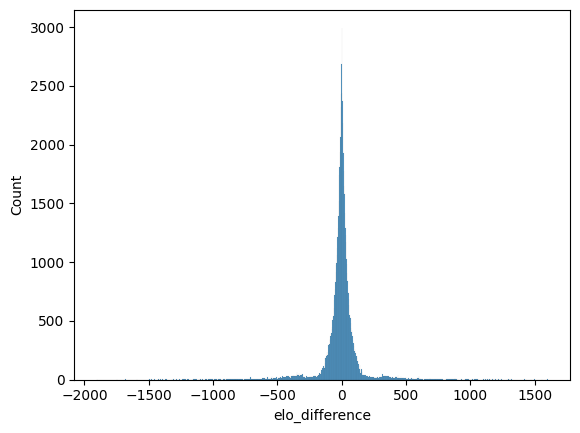

In [ ]:
sns.histplot(data = df_y)

In [ ]:
np.mean(df_y)

-6.981894355154841

511/511 [==============================] - 34s 65ms/step


<Axes: xlabel='y_test', ylabel='predict'>

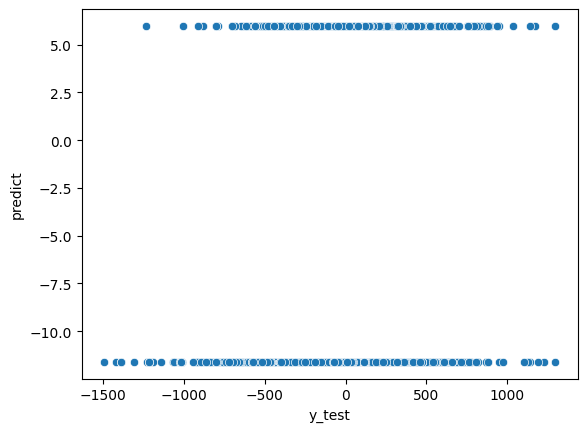

In [ ]:
df_res = pd.DataFrame(y_test)
df_res.columns = ['y_test']
df_res['predict'] = model.predict(X_test)
sns.scatterplot(x="y_test", y="predict", data=df_res)

In [ ]:
p_list = list(df_player[df_player['count'] >= 50]['index'])
df = df_org[df_org.player.isin(p_list)]

mms = MinMaxScaler()
df_X = mms.fit_transform(df.drop(columns = ['player', 'player_elo', 'opponent_elo', 'elo_difference', 'player_color', 'player_result']))
df_y = df['elo_difference']
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)
param_grid = [
      {
          'hidden_layer_sizes' : [(16, ), (64, ), (64, 16, ), (64, 64, 16)],
          'max_iter' : [500, 1000, 1500, 2000]
      }
      ]
clf = GridSearchCV(MLPRegressor(), param_grid, cv=3, scoring='r2')
clf.fit(X_train,y_train)
print("Best parameters set found on development set:")
print(clf.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
